In [117]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
import numpy.random as npr
import robust_loss_pytorch
from robust_loss_pytorch import distribution
import robust_loss_pytorch.general as general
import random
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)



In [100]:
def train_regular(model, trX, trY, dist, learning_rate=0.01, epoch=500, verbose=True):

    params = list(model.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(dist.loss(y_hat, trY))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            # You can see the alpha+scale parameters moving around.
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model


def train_adaptive(model, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
        num_dims=1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
    params = list(model.parameters()) + list(adaptive.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(adaptive.lossfun((y_hat - trY)[:,None]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            e, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))
    return model, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data


def train_locally_adaptive(model, alpha, scale, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    params = list(model.parameters()) + list(alpha.parameters()) + list(scale.parameters())
    dist = distribution.Distribution()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        alphas = torch.exp(alpha(trX))
        scales = torch.exp(scale(trX))
        loss = general.lossfun((y_hat - trY)[:, None], alpha=alphas, scale=scales, approximate=False)
        log_partition = torch.log(scales) + dist.log_base_partition_function(alphas)
        loss = (loss + log_partition).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model, alpha, scale


class PolyRegression(nn.Module):
    def __init__(self, dim, init_zeros=False):
        super(PolyRegression, self).__init__()
        self.beta = nn.Linear(dim, 1)
        self.n_poly = dim
        if init_zeros:
            with torch.no_grad():
                self.beta.weight.copy_(torch.zeros(dim))
                self.beta.bias.copy_(torch.zeros(1))

    def forward(self, x):
        """
        x: N x dim
        """
        expand = [(x**(i+1)).view(-1, 1) for i in range(self.n_poly)]
        expand = torch.cat(expand, dim=1)
        return self.beta(expand)


class AdaptiveRegression(nn.Module):
    def __init__(self):
        pass

    def forward(self, x):
        pass

In [164]:
class Gaussian(object):
    def loss(self, x, y):
        return (x-y)**2

    def loglikelihood(self, res, sigma=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if sigma is None:
            sigma = np.mean(res**2)
        N = len(res)
        ll = -N/2*np.log(2*np.pi*sigma) - 1/(2*sigma)*np.sum(res**2)
        return ll


class Laplace(object):
    def loss(self, x, y):
        return torch.abs(x-y)

    def loglikelihood(self, res, b=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if b is None:
            b = np.sqrt(np.mean(res ** 2)/2)
        N = len(res)
        ll = -N*np.log(2*b) - 1/b*np.sum(np.abs(res))
        return ll


class Adaptive(object):
    def loglikelihood(self, res, alpha, scale):
        assert alpha.view(-1).size()[0] == 1 or alpha.view(-1).size()[0] == len(res)
        N = len(res)
        dist = distribution.Distribution()
        loss = general.lossfun(res, alpha, scale, approximate=False).sum()
        log_partition = torch.log(scale) + dist.log_base_partition_function(alpha)
        if alpha.view(-1).size()[0] == 1:
            log_partition = N*log_partition
        else:
            log_partition = log_partition.sum()
        nll = loss + log_partition
        return -nll.detach().numpy()

    def sample(self, alpha, c):
        alpha = torch.as_tensor(alpha)
        scale = torch.as_tensor(c)
        assert (alpha >= 0).all()
        assert (scale >= 0).all()
        float_dtype = alpha.dtype
        assert scale.dtype == float_dtype

        cauchy = torch.distributions.cauchy.Cauchy(0., np.sqrt(2.))
        uniform = torch.distributions.uniform.Uniform(0, 1)
        samples = torch.zeros_like(alpha)
        accepted = torch.zeros(alpha.shape).type(torch.bool)
        dist = distribution.Distribution()
        while not accepted.type(torch.uint8).all():
            # Draw N samples from a Cauchy, our proposal distribution.
            cauchy_sample = torch.reshape(
              cauchy.sample((np.prod(alpha.shape),)), alpha.shape)
            cauchy_sample = cauchy_sample.type(alpha.dtype)

            # Compute the likelihood of each sample under its target distribution.
            nll = dist.nllfun(cauchy_sample,
                            torch.as_tensor(alpha).to(cauchy_sample),
                            torch.tensor(1).to(cauchy_sample))

            # Bound the NLL. We don't use the approximate loss as it may cause
            # unpredictable behavior in the context of sampling.
            nll_bound = general.lossfun(
              cauchy_sample,
              torch.tensor(0., dtype=cauchy_sample.dtype),
              torch.tensor(1., dtype=cauchy_sample.dtype),
              approximate=False) + dist.log_base_partition_function(alpha)

            # Draw N samples from a uniform distribution, and use each uniform sample
            # to decide whether or not to accept each proposal sample.
            uniform_sample = torch.reshape(
              uniform.sample((np.prod(alpha.shape),)), alpha.shape)
            uniform_sample = uniform_sample.type(alpha.dtype)
            accept = uniform_sample <= torch.exp(nll_bound - nll)

            # If a sample is accepted, replace its element in `samples` with the
            # proposal sample, and set its bit in `accepted` to True.
            samples = torch.where(accept, cauchy_sample, samples)
            accepted = accepted | accept

            # Because our distribution is a location-scale family, we sample from
            # p(x | 0, \alpha, 1) and then scale each sample by `scale`.
            samples *= scale
        return samples

# Heteroskedastic data: LIDAR

c:\users\cecilia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


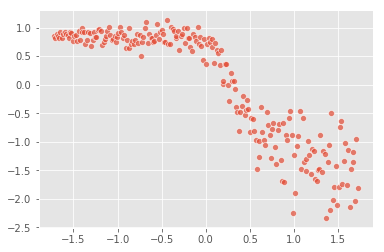

In [169]:
X = pd.read_csv('../dataset/lidar.tsv', sep='  ')
x_range = X['range']
y_ratio = X['logratio']
x_range = np.array((x_range-np.mean(x_range))/np.std(x_range))
y_ratio = np.array((y_ratio-np.mean(y_ratio))/np.std(y_ratio))
sns.scatterplot(x_range, y_ratio, alpha=0.7)
plt.show()

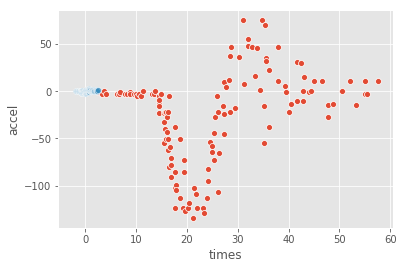

In [171]:
X = pd.read_csv('../dataset/mcycle.csv')
sns.scatterplot(X['times'], X['accel'])
N = len(X)
x_motor = X['times']
y_motor = X['accel']
x_motor = scaler(x_motor)
y_motor = scaler(y_motor)
sns.scatterplot(x_motor, y_motor, alpha=0.7)
plt.show()

In [205]:
dataset = 'lidar'   #'motor'

if dataset=='lidar':
    trX, teX, trY, teY = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
elif dataset=='motor':
    trX, teX, trY, teY = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)

In [206]:
print(trX.shape, trY.shape)

(154,) (154,)


In [207]:
gaussian = Gaussian()
laplace = Laplace()
adaptive = Adaptive()

## Polynomial regression with regular, adaptive and locally adaptive

In [220]:
x, y = torch.Tensor(trX), torch.Tensor(trY)

# define regression degree
reg_degree = 2

# define regression model
lr = PolyRegression(reg_degree)

# regular loss training
reg_fit = train_regular(lr, x, y, gaussian, epoch=1000, learning_rate=1e-2, verbose=False)

# ada loss training
ada_fit, alpha, scale = train_adaptive(lr, x, y, learning_rate=0.01, epoch=500, verbose=False)

# adalocal loss training
alpha_model = PolyRegression(2, init_zeros=True)
scale_model = PolyRegression(2, init_zeros=True)
ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, trainX, trainY, learning_rate=0.01, epoch=500, verbose=False)

100%|███████████████████████████████████████| 500/500 [00:02<00:00, 224.52it/s]


In [221]:
sortedx, idxX = torch.sort(trainX)
y2 = reg_fit(sortedx).detach()
yar = ada_fit(sortedx).detach().view(-1)
yalr = ada_loc_fit(sortedx).detach().view(-1)
alphas = torch.exp(alpha_model(sortedx).view(-1))
scales = torch.exp(scale_model(sortedx).view(-1))

In [223]:
print('Adaptive Log Likelihood: ', adaptive.loglikelihood(yar-y[idxX], alpha, scale))
print('Ada+reg Log Likelihood : ', adaptive.loglikelihood(yalr-y[idxX], alphas, scales))

Adaptive Log Likelihood:  -72.38838
Ada+reg Log Likelihood :  -6.452667


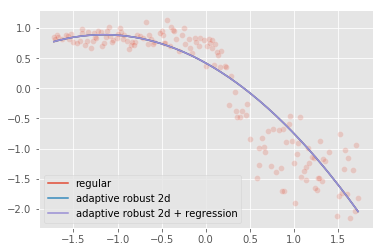

In [226]:
sns.scatterplot(trX, trY, alpha=0.2)
sns.lineplot(sortedx.detach().numpy(), y2.detach().numpy().flatten(), label='regular')
sns.lineplot(sortedx.detach().numpy(), yar.detach().numpy().flatten(), label='adaptive robust 2d')
sns.lineplot(sortedx.detach().numpy(), yalr.detach().numpy().flatten(), label='adaptive robust 2d + regression')